In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv


## Reading the files

In [2]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier  # Import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load train and test data
train = pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/train.csv")
test = pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/test.csv")


In [3]:
# Separate features and target variable
# Assuming 'target' is the name of the target column, replace with the actual name
X = train.drop('Crime_Category', axis=1)
y = train['Crime_Category']
# Encode categorical features
le = LabelEncoder()
encoded_X = X.apply(le.fit_transform)

In [4]:

from sklearn.feature_selection import chi2
# Apply Chi-Square test
chi2_values, p_values = chi2(encoded_X, y)

# Create a DataFrame to see the results
chi2_results = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Value': chi2_values,
    'P-Value': p_values
})

# Display the results
print(chi2_results.sort_values(by='Chi2 Value', ascending=False))

                  Feature     Chi2 Value        P-Value
11         Modus_Operandi  787665.098866   0.000000e+00
0                Location  255689.993791   0.000000e+00
15           Premise_Code   92063.316089   0.000000e+00
3               Longitude   71586.980966   0.000000e+00
2                Latitude   34015.423131   0.000000e+00
1            Cross_Street   19844.466248   0.000000e+00
12             Victim_Age   18144.633177   0.000000e+00
17       Weapon_Used_Code   17692.550262   0.000000e+00
6           Time_Occurred   15055.136844   0.000000e+00
18     Weapon_Description    9704.874250   0.000000e+00
14         Victim_Descent    8144.071185   0.000000e+00
10               Part 1-2    4393.678087   0.000000e+00
13             Victim_Sex    3032.996050   0.000000e+00
9   Reporting_District_no    2074.598976   0.000000e+00
4           Date_Reported    1725.644906   0.000000e+00
5           Date_Occurred     810.216912  7.127888e-173
19                 Status     628.894360  1.1536

Hence from the above  Chi-Square tests, it is evident that these feature have a significant Chi2 calue and a small p-value. Therefore, i decided to retain these 


## Dropping unnecessary columns

In [5]:
# Dropign unnecessary columns
columns_to_drop = ['Cross_Street', 'Weapon_Used_Code', 'Weapon_Description', 'Location', 'Date_Reported', 'Date_Occurred', 'Area_Name', 'Premise_Description']
train.drop(columns=columns_to_drop, inplace=True)
test.drop(columns=columns_to_drop, inplace=True)


## EDA:

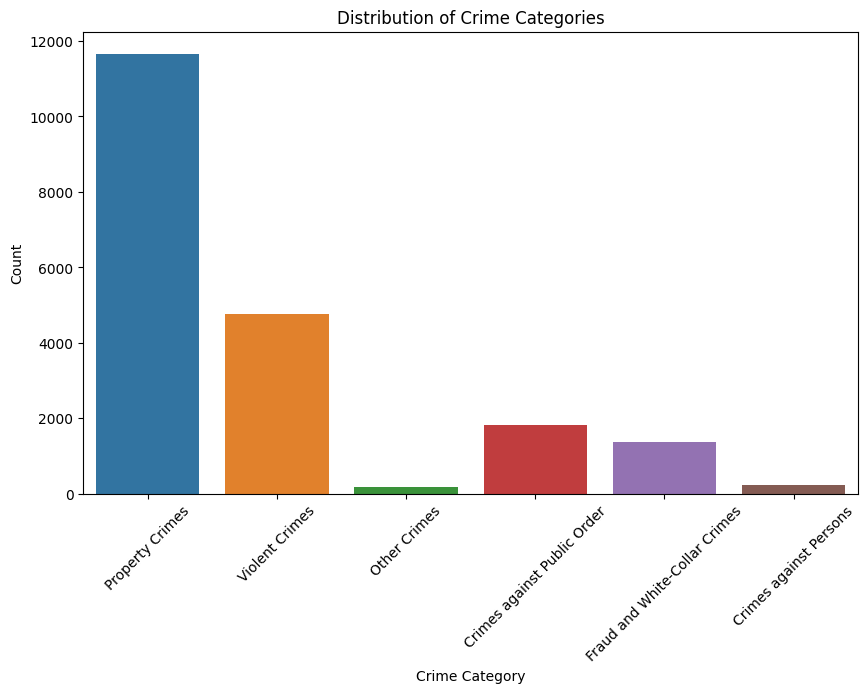

In [6]:
# Distribution of Crime Categories
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=train, x='Crime_Category')
plt.title('Distribution of Crime Categories')
plt.xlabel('Crime Category')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

From this above bar chart we can clearly see the distribution of the Crime Category variable(target feature)

<Figure size 1500x1000 with 0 Axes>

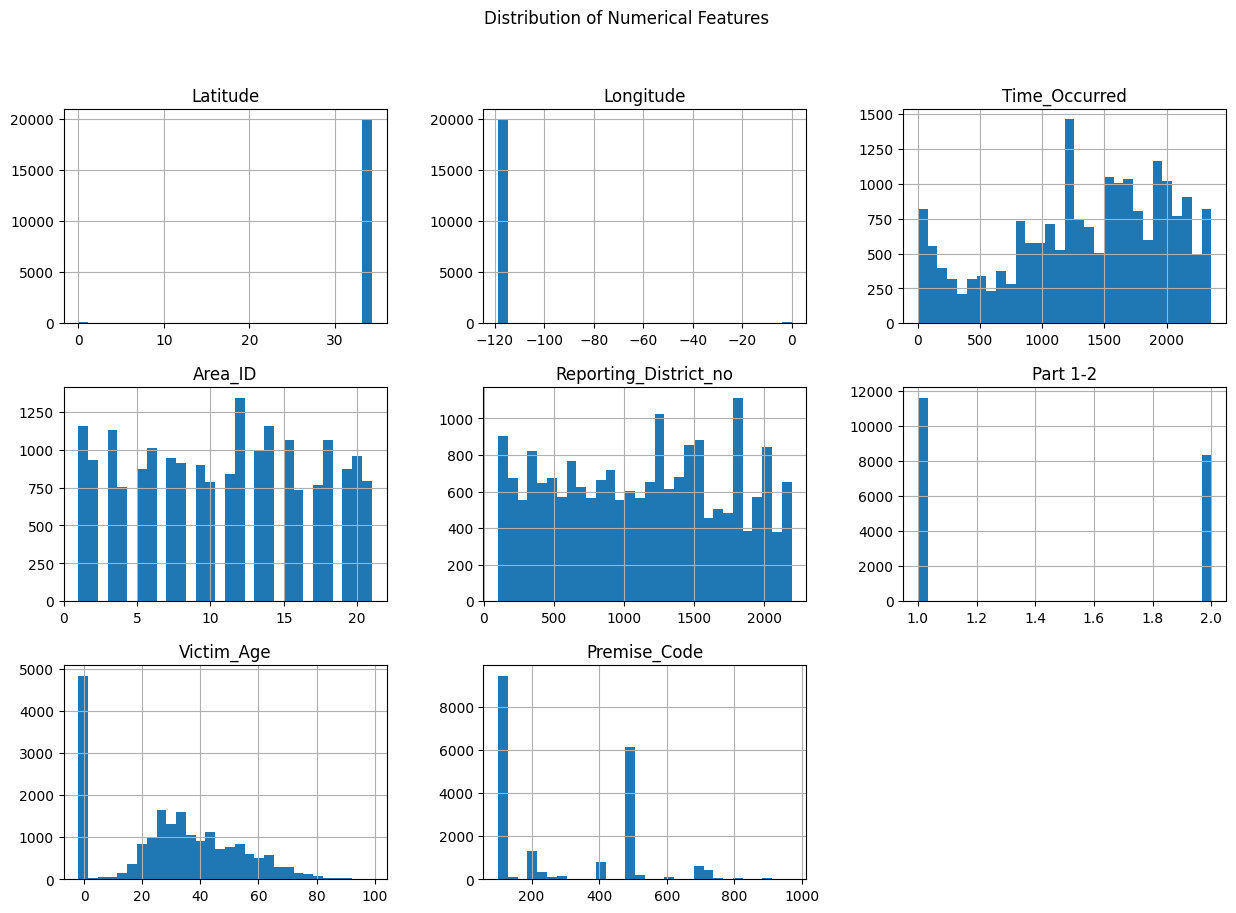

In [7]:
# Distribution of Numerical Features
numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features = train[numerical_columns]

plt.figure(figsize=(15, 10))
numerical_features.hist(figsize=(15, 10), bins=30)
plt.suptitle('Distribution of Numerical Features')
plt.show()

Here, i created the distribution of numberical features

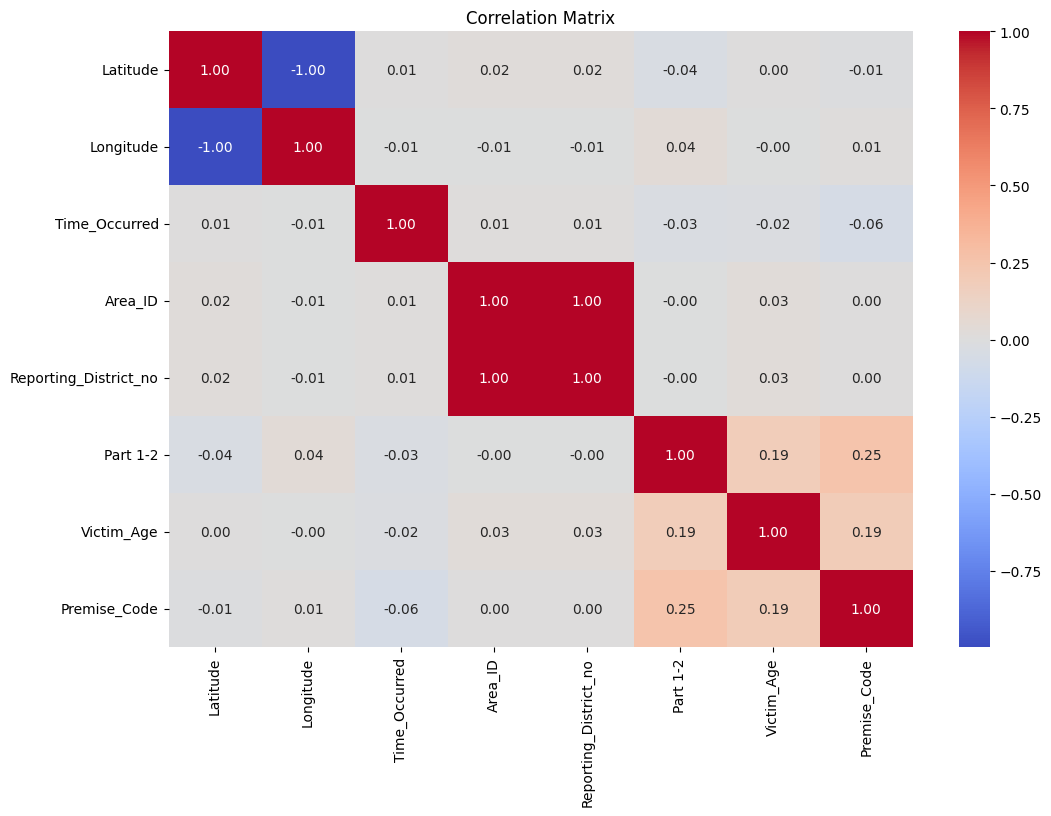

In [8]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
correlation_matrix = numerical_features.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()



Some key observation:

Area_ID and Reporting_District_no have a perfect correlation (1.00), indicating that they are likely representing the same or highly related information.

Part 1-2 and Premise_Code show a moderately positive correlation (0.25), suggesting some level of association between these variables.
Victim_Age and Premise_Code also show a positive correlation (0.19), indicating some relationship.



## Performing EDA especially on the modus_operandi feature

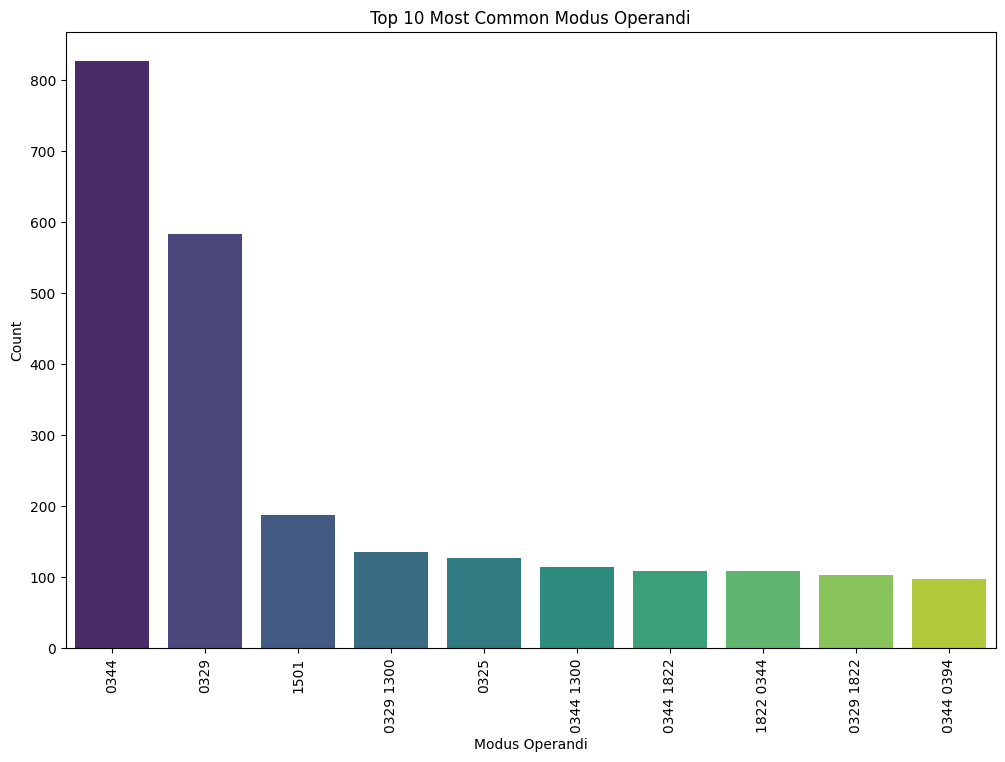

In [9]:
# 8. Modus Operandi Analysis
# Get the top N most common modus operandi
top_n = 10
modus_operandi_counts = train['Modus_Operandi'].value_counts().head(top_n)

plt.figure(figsize=(12, 8))
sns.barplot(x=modus_operandi_counts.index, y=modus_operandi_counts.values, palette='viridis')
plt.title(f'Top {top_n} Most Common Modus Operandi')
plt.xlabel('Modus Operandi')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Here i have specially done a bar chart for just Modus Operandi for the top 10 most common labels

## Modus_Operandi 

ModusOperandiTransformer Class:

I designed this class to transform the 'Modus_Operandi' feature using a MulitLabelBinarizer. It inherits from BaseEstimator and TransformerMixin, which are classes from scikit-learn that allow the custom transformer to integrate seamlessly with scikit-learn's pipeline system.

In [10]:
# Custom Transformer for Modus Operandi
class ModusOperandiTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):                    #__init__ initializes the transformer without any additional parameters, ensuring the mlb is ready for use.
        self.mlb = MultiLabelBinarizer()  #self.mlb is an instance of MultiLabelBinarizer()

    def fit(self, X, y=None):
        modus_operandi_split = [str(x[0]).split() for x in X]  # splits each entry in X
        self.mlb.fit(modus_operandi_split) 
        return self

#     This method transforms the input data X using the fitted MultiLabelBinarizer

    def transform(self, X):
        modus_operandi_split = [str(x[0]).split() for x in X]  # transforms these lists into a binary matrix where each column represents a unique label from the original data.
        modus_operandi_encoded = self.mlb.transform(modus_operandi_split)
        return modus_operandi_encoded

During Fitting (fit Method): To determine all unique labels across the entire dataset, so the MultiLabelBinarizer can correctly identify and remember these labels.

During Transformation (transform Method): To ensure that the input data is in the same format (list of lists) that the MultiLabelBinarizer expects for transformation into a binary matrix. This ensures consistency in the data processing pipeline.

## Identifying categorical and numerical features


In [11]:
# Define column lists
categorical_columns = ['Victim_Sex', 'Victim_Descent', 'Status', 'Status_Description']
numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Crime_Category' in numerical_columns:
    numerical_columns.remove('Crime_Category')  # Remove the target variable if present

# Create transformers
modus_operandi_transformer = Pipeline(steps=[
    ('modus_imputer', SimpleImputer(strategy='most_frequent')),
    ('modus_binarizer', ModusOperandiTransformer())
])



## Handled the numerical and categorical features

Imputed the categorical and numerical cariables with the most frequent value

In [12]:
categorical_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='most_frequent')),
    ('num_scaler', StandardScaler())
])



In [13]:
# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('modus', modus_operandi_transformer, ['Modus_Operandi']),
        ('cat', categorical_transformer, categorical_columns),
        ('num', numerical_transformer, numerical_columns)
    ]
)

# Create pipelines for different classifiers
pipeline_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier())
])

pipeline_svc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

pipeline_mlp = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(max_iter=300))  # Added MLPClassifier with max_iter
])



## LGBMClassifier

In [14]:
# Encode the target variable
label_encoder = LabelEncoder()
train['Crime_Category'] = label_encoder.fit_transform(train['Crime_Category'])

X = train.drop('Crime_Category', axis=1)
y = train['Crime_Category']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and evaluate LGBMClassifier pipeline
pipeline_lgbm.fit(X_train, y_train)
y_pred_lgbm = pipeline_lgbm.predict(X_test)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print("LGBMClassifier Accuracy:", accuracy_lgbm)

# Decode the predictions back to original labels for LGBMClassifier
y_pred_lgbm_original = label_encoder.inverse_transform(y_pred_lgbm)

# Ensure test columns match train columns
missing_cols = set(X.columns) - set(test.columns)
for c in missing_cols:
    test[c] = 0
test = test[X.columns]

# Predictions on actual test data with LGBMClassifier
Predictions_On_Test_Data_lgbm = pipeline_lgbm.predict(test)
Predictions_On_Test_Data_lgbm_original = label_encoder.inverse_transform(Predictions_On_Test_Data_lgbm)

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Output the original labels for predictions
print("LGBMClassifier Predictions on Test Data (Original Labels):", Predictions_On_Test_Data_lgbm_original)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1645
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 198
[LightGBM] [Info] Start training from score -4.417654
[LightGBM] [Info] Start training from score -2.412121
[LightGBM] [Info] Start training from score -2.688248
[LightGBM] [Info] Start training from score -4.710531
[LightGBM] [Info] Start training from score -0.535823
[LightGBM] [Info] Start training from score -1.443394


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['0383', '0402', '0405', '0543', '0547', '0604', '0933', '0944', '0946', '1006', '1225', '1277', '1316', '1404', '1405', '1406', '2022', '2025', '2201'] will be ignored
  warnings.warn(


LGBMClassifier Accuracy: 0.95175


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['0218', '0306', '0320', '0383', '0393', '0403', '0518', '0540', '0543', '0854', '0946', '1011', '1225', '1231', '1255', '1277', '1314', '1316', '2022', '2026', '2043', '2044', '2208', '2308', '3030'] will be ignored
  warnings.warn(


Train shape: (20000, 14)
Test shape: (5000, 13)
LGBMClassifier Predictions on Test Data (Original Labels): ['Violent Crimes' 'Property Crimes' 'Fraud and White-Collar Crimes' ...
 'Violent Crimes' 'Violent Crimes' 'Property Crimes']


## HPT for LGBM

In [15]:
# Parameter grid for LGBMClassifier
# param_grid_lgbm = {
#     'classifier__num_leaves': [31, 50, 70],
#     'classifier__learning_rate': [0.01, 0.05, 0.1],
#     'classifier__n_estimators': [100, 200, 300]
# }


# # Hyperparameter tuning for LGBMClassifier
# grid_search_lgbm = GridSearchCV(pipeline_lgbm, param_grid_lgbm, cv=2, n_jobs=-1, scoring='accuracy')
# grid_search_lgbm.fit(X_train, y_train)
# best_lgbm = grid_search_lgbm.best_estimator_
# print("Best parameters for LGBMClassifier:", grid_search_lgbm.best_params_)
# print("Best cross-validated score for LGBMClassifier:", grid_search_lgbm.best_score_)


# # Evaluate the best LGBMClassifier
# y_pred_lgbm_best = best_lgbm.predict(X_test)
# accuracy_lgbm_best = accuracy_score(y_test, y_pred_lgbm_best)
# print("Best LGBMClassifier Accuracy:", accuracy_lgbm_best)





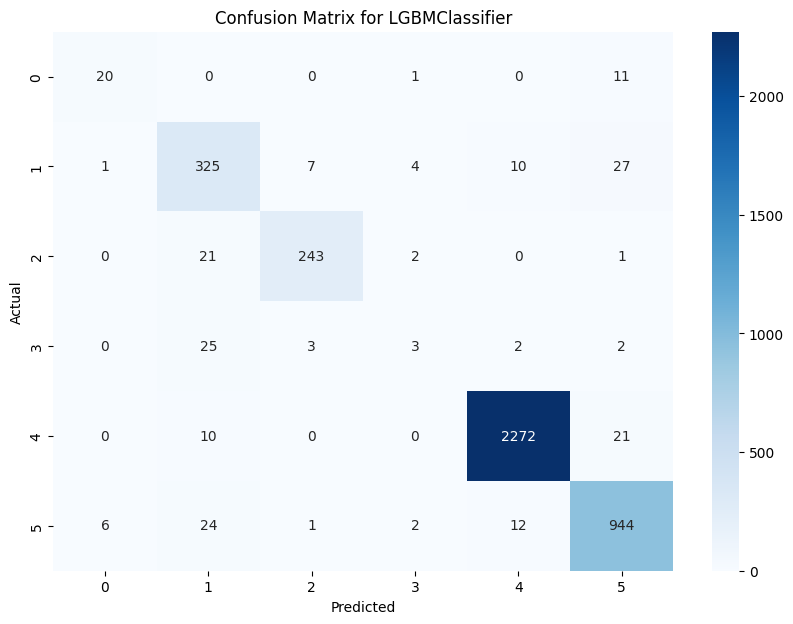

In [16]:
# Confusion matrix for LGBMClassifier
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for LGBMClassifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

To give a brief about the graph this is confusion matrix for an LGBMClassifier which i used to evaluate the performance of the model. Essentially what it does is show the actual versus predicted class labels for my dataset.

**The X-axis**: Shows the predicted classes by the model
**The Y-axis**: Shows the actual classes by the model

**Diagonal Elements in the matrix:**

The model correctly predicted class 0 for 20 instances.
The model correctly predicted class 1 for 325 instances.
The model correctly predicted class 4 for 2272 instances.

**Off-Diagonal Elements in the matrix:**

The model predicted class 5 instead of class 0 for 11 instances.
The model predicted class 1 instead of class 2 for 21 instances.

The color intensity indicates the number of instances. Darker colors represent a higher number of instances, while lighter colors represent fewer instances.

The classifier performs well for certain classes (like class 4 and class 5) but has more difficulty distinguishing between other classes (like class 0 and class 1).



## SVC

In [17]:
# Fit and evaluate SVC pipeline
pipeline_svc.fit(X_train, y_train)
y_pred_svc = pipeline_svc.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print("SVC Accuracy:", accuracy_svc)

# # Decode the predictions back to original labels for SVC
y_pred_svc_original = label_encoder.inverse_transform(y_pred_svc)

# Ensure test columns match train columns
missing_cols = set(X.columns) - set(test.columns)
for c in missing_cols:
    test[c] = 0
test = test[X.columns]

# Predictions on actual test data with SVC
Predictions_On_Test_Data_svc = pipeline_svc.predict(test)
Predictions_On_Test_Data_svc_original = label_encoder.inverse_transform(Predictions_On_Test_Data_svc)

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Output the original labels for predictions
print("SVC Predictions on Test Data (Original Labels):", Predictions_On_Test_Data_svc_original)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['0383', '0402', '0405', '0543', '0547', '0604', '0933', '0944', '0946', '1006', '1225', '1277', '1316', '1404', '1405', '1406', '2022', '2025', '2201'] will be ignored
  warnings.warn(


SVC Accuracy: 0.94025


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['0218', '0306', '0320', '0383', '0393', '0403', '0518', '0540', '0543', '0854', '0946', '1011', '1225', '1231', '1255', '1277', '1314', '1316', '2022', '2026', '2043', '2044', '2208', '2308', '3030'] will be ignored
  warnings.warn(


Train shape: (20000, 14)
Test shape: (5000, 13)
SVC Predictions on Test Data (Original Labels): ['Violent Crimes' 'Property Crimes' 'Fraud and White-Collar Crimes' ...
 'Violent Crimes' 'Violent Crimes' 'Property Crimes']


## HPT for SVC

In [18]:
# Parameter grid for SVC
# param_grid_svc = {
#     'classifier__C': [0.1, 1, 10],
#     'classifier__gamma': ['scale', 'auto'],
#     'classifier__kernel': ['linear', 'rbf']
# }

# # Hyperparameter tuning for SVC
# grid_search_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=5, n_jobs=-1, scoring='accuracy')
# grid_search_svc.fit(X_train, y_train)
# best_svc = grid_search_svc.best_estimator_
# print("Best parameters for SVC:", grid_search_svc.best_params_)
# print("Best cross-validated score for SVC:", grid_search_svc.best_score_)

# # Evaluate the best SVC
# y_pred_svc_best = best_svc.predict(X_test)
# accuracy_svc_best = accuracy_score(y_test, y_pred_svc_best)
# print("Best SVC Accuracy:", accuracy_svc_best)

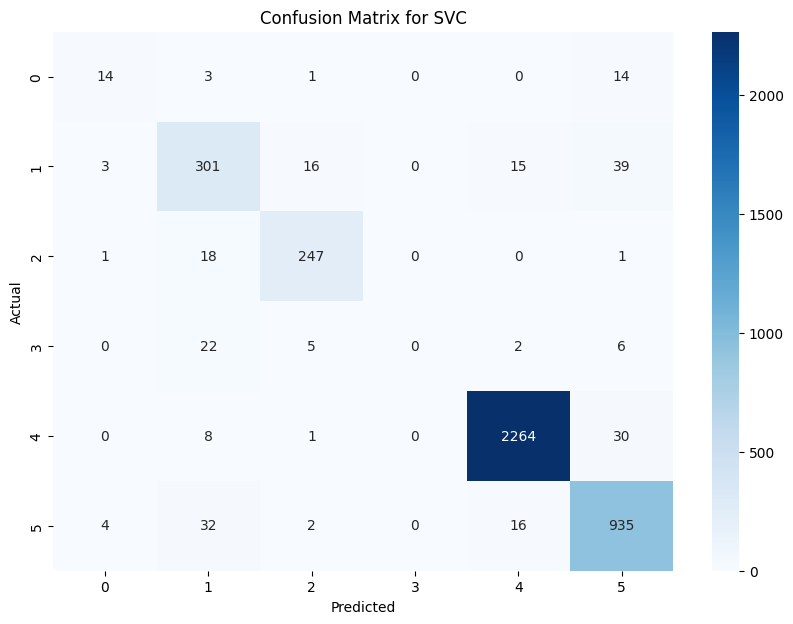

In [19]:
# Confusion matrix for SVC
cm_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for SVC')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## MLPClassifier

In [20]:
# Fit and evaluate MLPClassifier pipeline
pipeline_mlp.fit(X_train, y_train)
y_pred_mlp = pipeline_mlp.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print("MLPClassifier Accuracy:", accuracy_mlp)


# Decode the predictions back to original labels for MLPClassifier
y_pred_mlp_original = label_encoder.inverse_transform(y_pred_mlp)

# Ensure test columns match train columns
missing_cols = set(X.columns) - set(test.columns)
for c in missing_cols:
    test[c] = 0
test = test[X.columns]


# Predictions on actual test data with MLPClassifier
Predictions_On_Test_Data_mlp = pipeline_mlp.predict(test)
Predictions_On_Test_Data_mlp_original = label_encoder.inverse_transform(Predictions_On_Test_Data_mlp)

print("Train shape:", train.shape)
print("Test shape:", test.shape)


# Output the original labels for predictions
print("MLPClassifier Predictions on Test Data (Original Labels):", Predictions_On_Test_Data_mlp_original)

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['0383', '0402', '0405', '0543', '0547', '0604', '0933', '0944', '0946', '1006', '1225', '1277', '1316', '1404', '1405', '1406', '2022', '2025', '2201'] will be ignored
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['0218', '0306', '0320', '0383', '0393', '0403', '0518', '0540', '0543', '0854', '0946', '1011', '1225', '1231', '1255', '1277', '1314', '1316', '2022', '2026', '2043', '2044', '2208', '2308', '3030'] will be ignored
  warnings.warn(


MLPClassifier Accuracy: 0.93375
Train shape: (20000, 14)
Test shape: (5000, 13)
MLPClassifier Predictions on Test Data (Original Labels): ['Violent Crimes' 'Property Crimes' 'Fraud and White-Collar Crimes' ...
 'Violent Crimes' 'Violent Crimes' 'Property Crimes']


## HPT for MLPClassifier

In [21]:
# # Parameter grid for MLPClassifier
# param_grid_mlp = {
#     'classifier__hidden_layer_sizes': [(50, 50), (100,)],
#     'classifier__activation': ['relu', 'tanh'],
#     'classifier__solver': ['adam', 'sgd'],
#     'classifier__alpha': [0.0001, 0.001],
#     'classifier__learning_rate': ['constant', 'adaptive']
# }

# # Hyperparameter tuning for MLPClassifier
# grid_search_mlp = GridSearchCV(pipeline_mlp, param_grid_mlp, cv=5, n_jobs=-1, scoring='accuracy')
# grid_search_mlp.fit(X_train, y_train)
# best_mlp = grid_search_mlp.best_estimator_
# print("Best parameters for MLPClassifier:", grid_search_mlp.best_params_)
# print("Best cross-validated score for MLPClassifier:", grid_search_mlp.best_score_)

# # Evaluate the best MLPClassifier
# y_pred_mlp_best = best_mlp.predict(X_test)
# accuracy_mlp_best = accuracy_score(y_test, y_pred_mlp_best)
# print("Best MLPClassifier Accuracy:", accuracy_mlp_best)

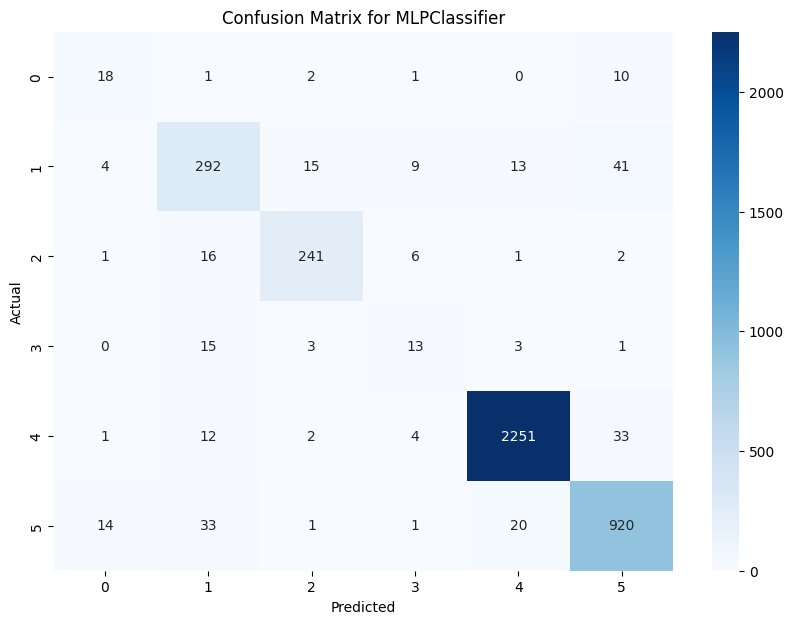

In [22]:
# Confusion matrix for MLPClassifier
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for MLPClassifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Model Performance Comparison

| Model             | Accuracy  | Description                                                                                                          |
|-------------------|-----------|----------------------------------------------------------------------------------------------------------------------|
| **LGBMClassifier**| 0.95175   | The LightGBM (LGBMClassifier) is a gradient boosting framework that uses tree-based learning algorithms. It is designed for speed and performance, making it highly efficient for large datasets and capable of handling complex data relationships. It is also known for its ability to handle categorical features directly and for its efficiency in memory usage. |
| **SVC**           | 0.94025   | The Support Vector Classifier (SVC) is a type of Support Vector Machine (SVM) used for classification tasks. SVC works by finding the hyperplane that best separates the classes in the feature space. It is effective for high-dimensional spaces and cases where the number of dimensions is greater than the number of samples. However, it can be computationally intensive for large datasets. |
| **MLPClassifier** | 0.929     | The Multi-Layer Perceptron (MLPClassifier) is a type of artificial neural network (ANN). It consists of multiple layers of nodes, each layer fully connected to the next one. MLPClassifier is capable of capturing complex patterns in the data but requires careful tuning of hyperparameters and scaling of features. It is particularly useful for problems where the relationship between features and target is highly non-linear. |


## Therefore from the accuracy score and confusion matrix, LGBMClassifier is best suited model here

In [23]:
# Create a DataFrame for the submission
submission = pd.DataFrame({
    'ID': range(1, len( Predictions_On_Test_Data_lgbm_original) + 1),  # Using index as ID
    'Crime_Category':  Predictions_On_Test_Data_lgbm_original
})

In [24]:
# Save the submission DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)